ECE 9063 Data Analytics Project

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.8MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import kerastuner as kt


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Set Random Seeds

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Importing Data

In [ ]:
# ============== Importing data ======================
featureFile = 'combined_data.csv'
featureData = pd.read_csv(featureFile)

labelFile = 'SyedHouse-GreenButton-2018-07-01-2020-02-29.csv'
labelData = pd.read_csv(labelFile)

# put feature and label in one object
data = pd.concat([featureData, labelData['Usage (kilowatt-hours)']], axis=1)
data

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),Rel Hum Flag,Wind Dir (10s deg),Wind Dir Flag,Wind Spd (km/h),Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Usage (kilowatt-hours)
0,-81.15,43.03,LONDON A,6144473,2018-07-01 00:00,2018,7,1,00:00,25.0,NaN,20.9,NaN,78.0,NaN,21.0,NaN,10.0,NaN,24.1,NaN,98.35,NaN,33.0,NaN,NaN,NaN,NaN,3.53
1,-81.15,43.03,LONDON A,6144473,2018-07-01 01:00,2018,7,1,01:00,23.5,NaN,20.8,NaN,84.0,NaN,20.0,NaN,7.0,NaN,24.1,NaN,98.39,NaN,32.0,NaN,NaN,NaN,Clear,3.45
2,-81.15,43.03,LONDON A,6144473,2018-07-01 02:00,2018,7,1,02:00,22.9,NaN,20.6,NaN,86.0,NaN,19.0,NaN,5.0,NaN,24.1,NaN,98.39,NaN,31.0,NaN,NaN,NaN,NaN,3.36
3,-81.15,43.03,LONDON A,6144473,2018-07-01 03:00,2018,7,1,03:00,19.9,NaN,19.3,NaN,96.0,NaN,0.0,NaN,1.0,NaN,24.1,NaN,98.42,NaN,NaN,NaN,NaN,NaN,NaN,2.90
4,-81.15,43.03,LONDON A,6144473,2018-07-01 04:00,2018,7,1,04:00,20.1,NaN,19.6,NaN,97.0,NaN,26.0,NaN,5.0,NaN,24.1,NaN,98.38,NaN,27.0,NaN,NaN,NaN,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,-81.15,43.03,LONDON A,6144473,2020-02-29 19:00,2020,2,29,19:00,-6.7,NaN,-11.7,NaN,68.0,NaN,24.0,NaN,11.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-12.0,NaN,Mainly Clear,0.84
14612,-81.15,43.03,LONDON A,6144473,2020-02-29 20:00,2020,2,29,20:00,-7.0,NaN,-11.5,NaN,71.0,NaN,23.0,NaN,11.0,NaN,24.1,NaN,98.53,NaN,NaN,NaN,-12.0,NaN,NaN,0.88
14613,-81.15,43.03,LONDON A,6144473,2020-02-29 21:00,2020,2,29,21:00,-7.1,NaN,-11.2,NaN,73.0,NaN,20.0,NaN,9.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-11.0,NaN,NaN,0.98
14614,-81.15,43.03,LONDON A,6144473,2020-02-29 22:00,2020,2,29,22:00,-9.1,NaN,-12.0,NaN,80.0,NaN,20.0,NaN,8.0,NaN,24.1,NaN,98.52,NaN,NaN,NaN,-13.0,NaN,Clear,0.93


<Figure size 720x360 with 0 Axes>

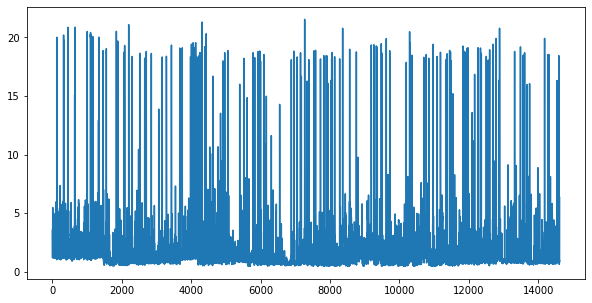

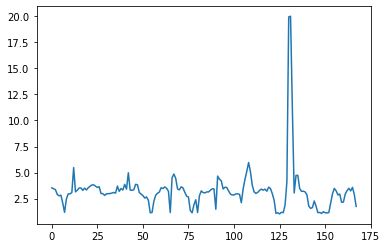

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data['Usage (kilowatt-hours)'])
plt.show()

# close up on the first week
plt.plot(data['Usage (kilowatt-hours)'].head(168))
plt.show()

Data Cleaning

In [ ]:
# ================= Data Cleaning =======================

# drop the columns with mostly missing values
data = data.drop(columns=["Temp Flag", "Dew Point Temp Flag", "Rel Hum Flag", "Wind Dir Flag", "Wind Spd Flag",
                   "Visibility Flag", "Stn Press Flag", "Hmdx", "Hmdx Flag", "Wind Chill", "Wind Chill Flag"])

# drop columns with constant data
data = data.drop(columns=["Longitude (x)", "Latitude (y)", "Station Name", "Climate ID", 'Date/Time'])

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    9
Dew Point Temp (°C)          9
Rel Hum (%)                  9
Wind Dir (10s deg)          19
Wind Spd (km/h)              9
Visibility (km)              8
Stn Press (kPa)              9
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


In [ ]:
# Deal with missing values
columns_to_clean = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
                    "Visibility (km)", "Stn Press (kPa)"]

# replace with previous hour data
for col in columns_to_clean:
    data[col].fillna(method='ffill', inplace=True)

print(data.isnull().sum())

Year                         0
Month                        0
Day                          0
Time                         0
Temp (°C)                    0
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           0
Wind Spd (km/h)              0
Visibility (km)              0
Stn Press (kPa)              0
Weather                   7211
Usage (kilowatt-hours)       0
dtype: int64


Weather Attribute

In [ ]:
# clean the "weather" attribute: replace missing values with previous observations
data["Weather"].fillna(method='ffill', inplace=True)

print(data.isnull().sum())

Year                      0
Month                     0
Day                       0
Time                      0
Temp (°C)                 0
Dew Point Temp (°C)       0
Rel Hum (%)               0
Wind Dir (10s deg)        0
Wind Spd (km/h)           0
Visibility (km)           0
Stn Press (kPa)           0
Weather                   0
Usage (kilowatt-hours)    0
dtype: int64


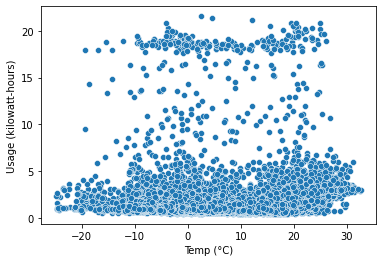

In [ ]:
sns.scatterplot(data=data, x="Temp (°C)", y="Usage (kilowatt-hours)")

Feature Engineering

Hour of the day

In [ ]:
data['Time'] = data['Time'].apply(lambda s: float(s.split(':')[0]))
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours)
0,2018,7,1,0.0,25.0,20.9,78.0,21.0,10.0,24.1,98.35,Clear,3.53
1,2018,7,1,1.0,23.5,20.8,84.0,20.0,7.0,24.1,98.39,Clear,3.45
2,2018,7,1,2.0,22.9,20.6,86.0,19.0,5.0,24.1,98.39,Clear,3.36
3,2018,7,1,3.0,19.9,19.3,96.0,0.0,1.0,24.1,98.42,Clear,2.90
4,2018,7,1,4.0,20.1,19.6,97.0,26.0,5.0,24.1,98.38,Mainly Clear,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14611,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84
14612,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88
14613,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98
14614,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93


Day of the week

In [ ]:
day_week = []
counter = 0

for day in range(len(data)):
  if 0<= counter <= 23:
    day_week.append(7)
  elif 24 <= counter <=47:
    day_week.append(1)
  elif 48<= counter <= 71:
    day_week.append(2)
  elif 72 <= counter <= 95:
    day_week.append(3)
  elif 96 <= counter <=119:
    day_week.append(4)
  elif 120 <=counter <= 143:
    day_week.append(5)
  elif 144 <= counter <=167:
    day_week.append(6)
  
  counter += 1

  if counter > 167:
    counter = 0

day_week = pd.DataFrame(data=day_week, columns=['day_week'])
day_week

data = pd.concat([data, day_week], axis=1)

,day_week
0,7
1,7
2,7
3,7
4,7
...,...
14611,6
14612,6
14613,6
14614,6


Previous usage at features

In [ ]:
steps = 7

for i in range(1,steps):
  data['Previous_Usage' + str(i)] = data['Usage (kilowatt-hours)'].shift(i)
  
for i in range(steps-1):
  data.drop(index=i, inplace=True)

data = pd.DataFrame.reset_index(data, drop=True)
data

,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather,Usage (kilowatt-hours),day_week,Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6
0,2018,7,1,6.0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,Mainly Clear,2.08,7,2.83,2.77,2.90,3.36,3.45,3.53
1,2018,7,1,7.0,24.8,21.8,83.0,19.0,9.0,24.1,98.43,Mainly Clear,1.18,7,2.08,2.83,2.77,2.90,3.36,3.45
2,2018,7,1,8.0,26.6,22.7,79.0,18.0,9.0,24.1,98.44,Mainly Clear,2.46,7,1.18,2.08,2.83,2.77,2.90,3.36
3,2018,7,1,9.0,28.2,23.4,75.0,18.0,14.0,24.1,98.46,Mainly Clear,2.95,7,2.46,1.18,2.08,2.83,2.77,2.90
4,2018,7,1,10.0,29.4,23.7,71.0,17.0,14.0,24.1,98.42,Mainly Clear,2.96,7,2.95,2.46,1.18,2.08,2.83,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,2020,2,29,19.0,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,Mainly Clear,0.84,6,0.87,0.71,0.83,0.67,0.86,0.82
14606,2020,2,29,20.0,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,Mainly Clear,0.88,6,0.84,0.87,0.71,0.83,0.67,0.86
14607,2020,2,29,21.0,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,Mainly Clear,0.98,6,0.88,0.84,0.87,0.71,0.83,0.67
14608,2020,2,29,22.0,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,Clear,0.93,6,0.98,0.88,0.84,0.87,0.71,0.83


Season Feature

In [ ]:
season = []
for month in data['Month']:
  if 4 <= month <= 5:
    season.append(1)
  elif 6 <= month <= 9:
    season.append(2)
  elif 10 <= month <= 11:
    season.append(3)
  elif 12 == month or month <= 3:
    season.append(4)

season = pd.DataFrame(data=season, columns=['Season'])
season

data = pd.concat([data, season], axis=1)

,Season
0,2
1,2
2,2
3,2
4,2
...,...
14605,4
14606,4
14607,4
14608,4


Unit Circle Mapping for Cyclical Features

In [ ]:
def encode_cyclical(data, col, max_val):
  data[col + '_sin'] = np.sin(2*np.pi*data[col]/max_val)
  data[col + '_cos'] = np.cos(2*np.pi*data[col]/max_val)

  data.drop(columns=[col], inplace=True)
  return data


data = encode_cyclical(data, 'Month', 12)
data = encode_cyclical(data, 'Time', 24)
data = encode_cyclical(data, 'Season', 4)
data = encode_cyclical(data, 'day_week', 7)

In [ ]:
data_onehot = data.copy()

# Discard Weather and Year feature
data_onehot = data_onehot.drop(columns=['Weather', 'Year', 'Day'], axis=1)

data_onehot

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Usage (kilowatt-hours),Previous_Usage1,Previous_Usage2,Previous_Usage3,Previous_Usage4,Previous_Usage5,Previous_Usage6,Month_sin,Month_cos,Time_sin,Time_cos,Season_sin,Season_cos,day_week_sin,day_week_cos
0,21.8,20.8,94.0,16.0,4.0,16.1,98.39,2.08,2.83,2.77,2.90,3.36,3.45,3.53,-0.500000,-0.866025,1.000000,6.123234e-17,1.224647e-16,-1.0,-2.449294e-16,1.00000
1,24.8,21.8,83.0,19.0,9.0,24.1,98.43,1.18,2.08,2.83,2.77,2.90,3.36,3.45,-0.500000,-0.866025,0.965926,-2.588190e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
2,26.6,22.7,79.0,18.0,9.0,24.1,98.44,2.46,1.18,2.08,2.83,2.77,2.90,3.36,-0.500000,-0.866025,0.866025,-5.000000e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
3,28.2,23.4,75.0,18.0,14.0,24.1,98.46,2.95,2.46,1.18,2.08,2.83,2.77,2.90,-0.500000,-0.866025,0.707107,-7.071068e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
4,29.4,23.7,71.0,17.0,14.0,24.1,98.42,2.96,2.95,2.46,1.18,2.08,2.83,2.77,-0.500000,-0.866025,0.500000,-8.660254e-01,1.224647e-16,-1.0,-2.449294e-16,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14605,-6.7,-11.7,68.0,24.0,11.0,24.1,98.52,0.84,0.87,0.71,0.83,0.67,0.86,0.82,0.866025,0.500000,-0.965926,2.588190e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349
14606,-7.0,-11.5,71.0,23.0,11.0,24.1,98.53,0.88,0.84,0.87,0.71,0.83,0.67,0.86,0.866025,0.500000,-0.866025,5.000000e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349
14607,-7.1,-11.2,73.0,20.0,9.0,24.1,98.52,0.98,0.88,0.84,0.87,0.71,0.83,0.67,0.866025,0.500000,-0.707107,7.071068e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349
14608,-9.1,-12.0,80.0,20.0,8.0,24.1,98.52,0.93,0.98,0.88,0.84,0.87,0.71,0.83,0.866025,0.500000,-0.500000,8.660254e-01,-2.449294e-16,1.0,-7.818315e-01,0.62349


Data Preprocessing

In [ ]:
df = data_onehot.copy()

# split into 60%:20%:20%
n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

# save the scaling of target variable
y_mean = train_df['Usage (kilowatt-hours)'].mean()
y_std = train_df['Usage (kilowatt-hours)'].std()

ori_y_train = train_df['Usage (kilowatt-hours)'].to_numpy().copy()
ori_y_test = test_df['Usage (kilowatt-hours)'].to_numpy().copy()

# standardization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


Sliding Window

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  #plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Modeling

In [ ]:
steps = 6
OUT_STEPS = 1

window = WindowGenerator(
    input_width=steps, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['Usage (kilowatt-hours)'])
window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Usage (kilowatt-hours)']

In [ ]:
# ========================= Hyper-parameters Tuning ==============================

# tune batch size
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch', values=[8, 16, 32])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)


def build_model(hp):
    model = keras.models.Sequential()

    hp_filters = hp.Choice('filters', values=[8, 16, 24])
    hp_neurons = hp.Choice('neurons', values=[30, 40, 50])
    hp_layers = hp.Choice('layers', values=[3, 4, 5, 6])
    hp_regularize = hp.Choice('regularize', values=[0.01, 0.02, 0.03])
    
    model.add(layers.Conv1D(filters=hp_filters, kernel_size=(steps, ), activation='elu', kernel_initializer='he_normal'))

    # hidden layers
    for layer in range(hp_layers):
        model.add(layers.Dense(units=hp_neurons, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(hp_regularize)))

    # output layer
    model.add(layers.Dense(1, kernel_initializer='he_normal'))

    optimizer = keras.optimizers.Nadam()
    model.compile(loss='mse', optimizer=optimizer)
    return model


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, mode='min')

tuner = MyTuner(build_model, objective='val_loss', max_trials=30, seed=42)

tuner.search(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping_cb])


Trial 30 Complete [00h 01m 32s]
val_loss: 0.5696390271186829

Best val_loss So Far: 0.541442334651947
Total elapsed time: 00h 55m 56s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# display tuning results
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 8
neurons: 30
layers: 3
regularize: 0.02
batch: 16
Score: 0.541442334651947
Trial summary
Hyperparameters:
filters: 8
neurons: 50
layers: 3
regularize: 0.02
batch: 8
Score: 0.5455470085144043
Trial summary
Hyperparameters:
filters: 8
neurons: 40
layers: 4
regularize: 0.01
batch: 8
Score: 0.5569853186607361
Trial summary
Hyperparameters:
filters: 24
neurons: 40
layers: 3
regularize: 0.02
batch: 8
Score: 0.5574154853820801
Trial summary
Hyperparameters:
filters: 24
neurons: 30
layers: 4
regularize: 0.01
batch: 8
Score: 0.5581582188606262
Trial summary
Hyperparameters:
filters: 8
neurons: 30
layers: 3
regularize: 0.01
batch: 8
Score: 0.5604660511016846
Trial summary
Hyperparameters:
filters: 24
neurons: 40
layers: 5
regularize: 0.01
batch: 16
Score: 0.5616958141326904
Trial summary
Hyperparameters:
filters: 16
neurons: 50
layers: 4
regula

In [ ]:
#Retain the optimal hyper-parameters found and re-train the model

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)

history = model.fit(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping_cb])

model.summary()

Epoch 1/100
274/274 [==============================] - 2s 6ms/step - loss: 3.9201 - val_loss: 3.0576
Epoch 2/100
274/274 [==============================] - 2s 6ms/step - loss: 2.5822 - val_loss: 2.1702
Epoch 3/100
274/274 [==============================] - 2s 6ms/step - loss: 1.8286 - val_loss: 1.5628
Epoch 4/100
274/274 [==============================] - 2s 6ms/step - loss: 1.3517 - val_loss: 1.1912
Epoch 5/100
274/274 [==============================] - 2s 6ms/step - loss: 1.0576 - val_loss: 0.9704
Epoch 6/100
274/274 [==============================] - 2s 6ms/step - loss: 0.8741 - val_loss: 0.8292
Epoch 7/100
274/274 [==============================] - 2s 6ms/step - loss: 0.7623 - val_loss: 0.7489
Epoch 8/100
274/274 [==============================] - 2s 6ms/step - loss: 0.6881 - val_loss: 0.6751
Epoch 9/100
274/274 [==============================] - 2s 6ms/step - loss: 0.6436 - val_loss: 0.6385
Epoch 10/100
274/274 [==============================] - 2s 6ms/step - loss: 0.6134 - val_lo

In [ ]:
# model = tf.keras.Sequential([
#     layers.Conv1D(filters=10, kernel_size=(steps, ), strides=1, activation='elu', kernel_initializer='he_normal'),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(30, activation='elu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02)),
#     layers.Dense(1, kernel_initializer='he_normal'),

# ])


# model.compile(loss='mse', optimizer='Nadam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, mode='min')

# history = model.fit(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping_cb])

# model.summary()

Plot Loss vs Epochs

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

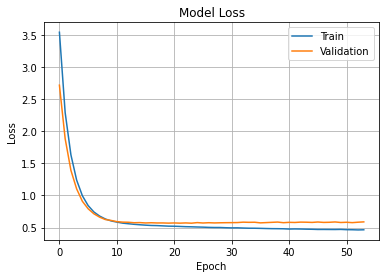

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

Accuracy & Evaluation

In [ ]:
ori_y_train = ori_y_train[steps:]
ori_y_test = ori_y_test[steps:]

(8760, 1, 1)
(8760,)
(8760,)
[1.4999349 1.5758649 3.326129  ... 2.633932  1.1821289 1.5064001]


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Train set')

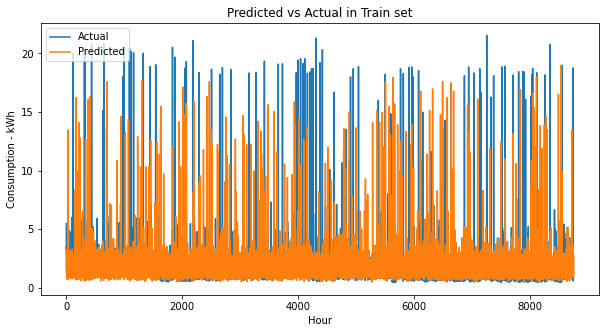

In [ ]:
# train set performance
Y_train_pred_scaled = model.predict(window.train)
print(np.shape(Y_train_pred_scaled))

Y_train_pred = Y_train_pred_scaled[:, -1, 0]

print(Y_train_pred.shape)
print(ori_y_train.shape)

# scale back
Y_train_pred = Y_train_pred * y_std + y_mean

print(Y_train_pred)

# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(ori_y_train, label='Actual')
plt.plot(Y_train_pred, label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Train set')
plt.legend(loc='upper left')
plt.show()

(2916, 1, 1)
(2916,)
(2916,)
[0.94849825 0.79875946 1.4878412  ... 1.3876352  1.3290069  2.580839  ]


<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Hour')

Text(0, 0.5, 'Consumption - kWh')

Text(0.5, 1.0, 'Predicted vs Actual in Test set')

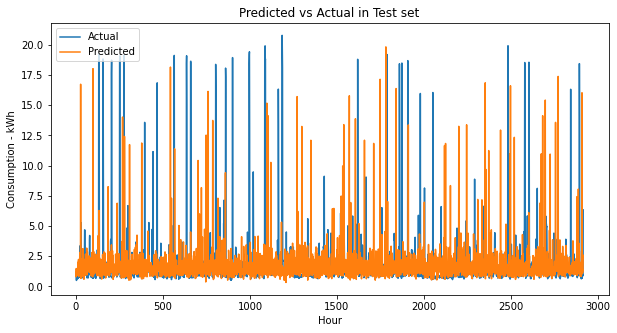

In [ ]:
# test set performance
Y_test_pred_scaled = model.predict(window.test)
print(np.shape(Y_test_pred_scaled))

Y_test_pred = Y_test_pred_scaled[:, -1, 0]

print(Y_test_pred.shape)
print(ori_y_test.shape)

# scale back
Y_test_pred = Y_test_pred * y_std + y_mean

print(Y_test_pred)

# visualize predicted vs actual in train set
plt.figure(figsize=(10,5))
plt.plot(ori_y_test, label='Actual')
plt.plot(Y_test_pred, label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Consumption - kWh')
plt.title('Predicted vs Actual in Test set')
plt.legend(loc='upper left')
plt.show()

In [ ]:
mape = tf.keras.losses.MeanAbsolutePercentageError()

In [ ]:
# Error Metric summary
model_performance = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])

Train_MAE = mean_absolute_error(ori_y_train, Y_train_pred).round(2)
Train_RMSE = np.sqrt(mean_squared_error(ori_y_train, Y_train_pred)).round(2)
train_mape = mape(ori_y_train, Y_train_pred).numpy().round(2)
print(train_mape)

Test_MAE = mean_absolute_error(ori_y_test, Y_test_pred).round(2)
Test_RMSE = np.sqrt(mean_squared_error(ori_y_test, Y_test_pred)).round(2)
test_mape = mape(ori_y_test, Y_test_pred).numpy().round(2)
print(test_mape)

model_performance = model_performance.append({
                        'Train MAE': Train_MAE,
                        'Train RMSE': Train_RMSE,
                        'Test MAE': Test_MAE,
                        'Test RMSE': Test_RMSE},
                        ignore_index=True)

model_performance

90.52
87.02


,Train MAE,Train RMSE,Test MAE,Test RMSE
0,1.49,3.12,1.38,3.19
